In [1]:
import requests
import pandas as pd


import spotipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
client_id = "57fb64fab0af4711bef89b43ecac3361"
client_secret = "8bb73ad9b5f94d05a85dbcd27039103c"

In [3]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))


In [4]:
def get_audio_features(artist, max_songs=10000):
    # First get the artist ID
    results = sp.search(q=f'artist:{artist}', type='artist', limit=1)
    artist_id = results['artists']['items'][0]['id']
    
    albums = []
    results = sp.artist_albums(artist_id, album_type='album')
    albums.extend(results['items'])
    while results['next']:
        results = sp.next(results)
        albums.extend(results['items'])

    track_ids = []
    track_names = []
    for album in albums:
        results = sp.album_tracks(album['id'])
        track_ids.extend([track['id'] for track in results['items']])
        track_names.extend([track['name'] for track in results['items']])
        
        if len(track_ids) >= max_songs:
            track_ids = track_ids[:max_songs]
            track_names = track_names[:max_songs]
            break

    audio_features = []
    for i in range(0, len(track_ids), 50):
        audio_features += sp.audio_features(track_ids[i:i + 50])


    df = pd.DataFrame(audio_features)
    df['artist'] = artist
    df['song_name'] = track_names[:len(audio_features)]

    return df

In [5]:
artists = ['The Beatles']

df = pd.DataFrame()

for artist in artists:
    df_artist = get_audio_features(artist)
    df = pd.concat([df, df_artist])

df = df.reset_index(drop=True)
df.shape

(617, 20)

In [6]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist,song_name
0,0.484,0.771,7,-6.151,1,0.1300,0.00225,0.000000,0.718,0.679,133.603,audio_features,1u2yF3CsOvVOMP82AgP2gJ,spotify:track:1u2yF3CsOvVOMP82AgP2gJ,https://api.spotify.com/v1/tracks/1u2yF3CsOvVO...,https://api.spotify.com/v1/audio-analysis/1u2y...,158267,4,The Beatles,Taxman - 2022 Mix
1,0.606,0.304,0,-7.485,1,0.0414,0.85300,0.000000,0.340,0.808,137.891,audio_features,1Oo6F5Dn1s8hrUDUQuoCqB,spotify:track:1Oo6F5Dn1s8hrUDUQuoCqB,https://api.spotify.com/v1/tracks/1Oo6F5Dn1s8h...,https://api.spotify.com/v1/audio-analysis/1Oo6...,126467,4,The Beatles,Eleanor Rigby - 2022 Mix
2,0.559,0.479,11,-7.890,1,0.0281,0.09440,0.000000,0.269,0.658,103.392,audio_features,7sNSyrCw3F7qnMpl938JUZ,spotify:track:7sNSyrCw3F7qnMpl938JUZ,https://api.spotify.com/v1/tracks/7sNSyrCw3F7q...,https://api.spotify.com/v1/audio-analysis/7sNS...,180320,4,The Beatles,I'm Only Sleeping - 2022 Mix
3,0.460,0.600,5,-9.108,1,0.0472,0.70600,0.000043,0.063,0.679,124.210,audio_features,0NT88kD8fIXuwBOuXlPcmx,spotify:track:0NT88kD8fIXuwBOuXlPcmx,https://api.spotify.com/v1/tracks/0NT88kD8fIXu...,https://api.spotify.com/v1/audio-analysis/0NT8...,179867,4,The Beatles,Love You To - 2022 Mix
4,0.345,0.304,7,-9.477,1,0.0297,0.87000,0.000031,0.116,0.425,164.568,audio_features,47gNXRKcBJxu6bOvmyUroI,spotify:track:47gNXRKcBJxu6bOvmyUroI,https://api.spotify.com/v1/tracks/47gNXRKcBJxu...,https://api.spotify.com/v1/audio-analysis/47gN...,144907,4,The Beatles,"Here, There And Everywhere - 2022 Mix"


In [7]:
x = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]


scaler = StandardScaler()

x_prep = scaler.fit_transform(x)



In [8]:
K = range(2, 20)

inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(x_prep)
    inertia.append(kmeans.inertia_)

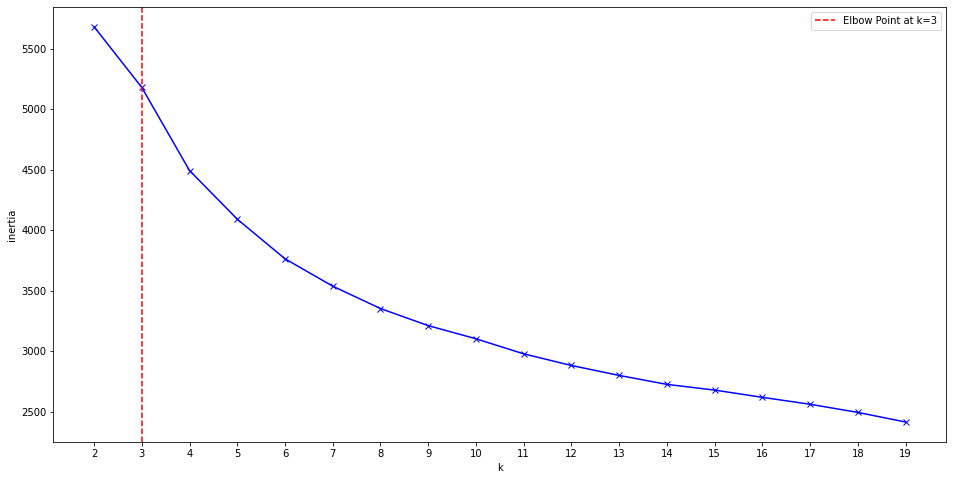

In [14]:

first_diff = np.diff(inertia)


second_diff = np.diff(first_diff)


elbow_point = np.argmax(second_diff) + 2  

plt.figure(figsize=(16, 8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K) + 1, 1.0))
plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow Point at k={elbow_point}')
plt.legend()
plt.show()


In [10]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_prep)

clusters = kmeans.predict(x_prep)

scaled_df = pd.DataFrame(x_prep, columns=x.columns)
scaled_df['song_name'] = df['song_name']
scaled_df['artist'] = df['artist']
scaled_df['cluster'] = clusters
scaled_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song_name,artist,cluster
0,-0.314519,1.254324,0.676974,1.280245,0.501519,0.210682,-1.300649,-0.354455,2.195423,0.269830,0.450534,Taxman - 2022 Mix,The Beatles,2
1,0.485751,-1.037352,-1.399625,0.900577,0.501519,-0.300581,1.385304,-0.354455,0.407972,0.783676,0.595474,Eleanor Rigby - 2022 Mix,The Beatles,0
2,0.177450,-0.178587,1.863603,0.785310,0.501519,-0.377328,-1.009717,-0.354455,0.072234,0.186181,-0.570644,I'm Only Sleeping - 2022 Mix,The Beatles,2
3,-0.471950,0.415187,0.083660,0.438657,0.501519,-0.267112,0.921202,-0.354238,-0.901879,0.269830,0.133036,Love You To - 2022 Mix,The Beatles,2
4,-1.226303,-1.037352,0.676974,0.333637,0.501519,-0.368095,1.438976,-0.354295,-0.651258,-0.741928,1.497197,"Here, There And Everywhere - 2022 Mix",The Beatles,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.498871,-0.104979,-0.212997,-0.444483,-1.993942,-0.340397,1.148517,-0.354455,-0.761909,1.066490,-0.265450,Baby It's You - Remastered 2009,The Beatles,0
613,0.925244,-0.816527,-0.212997,-0.502258,0.501519,-0.327125,0.611800,-0.354455,0.597121,-0.009001,0.141182,Do You Want To Know A Secret - Remastered 2009,The Beatles,0
614,-0.734333,-0.703661,-1.102968,-0.218219,-1.993942,-0.350784,0.895945,-0.354455,-0.708002,-0.793711,-0.637706,A Taste Of Honey - Remastered 2009,The Beatles,0
615,-0.504748,0.326857,-0.212997,0.182225,0.501519,-0.370980,0.678101,-0.354434,-0.386450,1.257689,0.698130,There's A Place - Remastered 2009,The Beatles,2


In [11]:
def find_song_features(artist, song_name):

    query = f"artist:{artist} track:{song_name}"
    result = sp.search(q=query, type='track')
    items = result['tracks']['items']
    
    if len(items) == 0:
        return None
    
    track_id = items[0]['id']
    
    audio_features = sp.audio_features([track_id])[0]
    return audio_features

In [12]:
def find_similar_beatles_songs(input_artist, input_song_name):
    audio_features = find_song_features(input_artist, input_song_name)
    
    if audio_features is None:
        return "The specified song was not found."
    
    # Create a DataFrame from the audio features
    input_df = pd.DataFrame([audio_features])
    
    # Extract features and scale them
    input_song_features = input_df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
    input_scaled_features = scaler.transform(input_song_features)
    
    input_song_cluster = kmeans.predict(input_scaled_features)
    beatles_songs_in_cluster = scaled_df[scaled_df['cluster'] == input_song_cluster[0]]

    distances = beatles_songs_in_cluster.apply(lambda row: distance.euclidean(row[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']], input_scaled_features), axis=1)
    

    beatles_songs_in_cluster['distance'] = distances
    beatles_songs_in_cluster = beatles_songs_in_cluster.sort_values('distance')
    
    # Return the top 5 most similar songs
    return beatles_songs_in_cluster.head(5)['song_name'].tolist()

In [13]:
find_similar_beatles_songs('Green day','American Idiot')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['One After 909 - Take 3',
 "Can't Buy Me Love - Remastered 2009",
 'Lovely Rita - Speech And Take 9',
 'Oh! Darling - 2019 Mix',
 'Love Me Do - Remastered 2009']